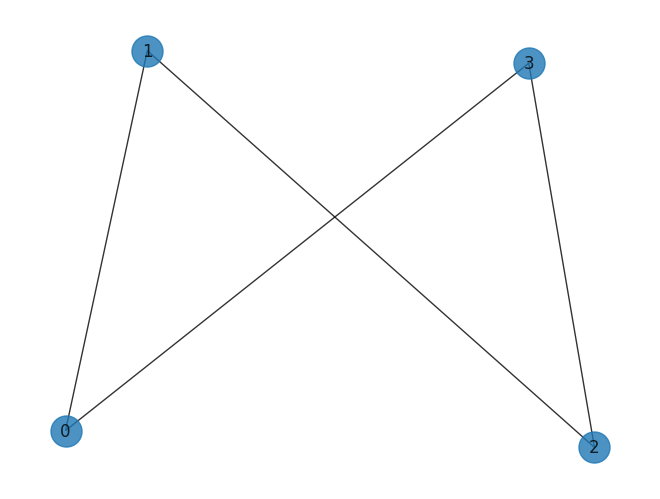

In [1]:
import networkx as nx
from networkx import Graph

g = Graph()
g.add_nodes_from([0, 1, 2, 3])
g.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(g, with_labels=True, alpha=0.8, node_size=500)

In [2]:
from tequila import gates

def mixer(g: Graph, beta: float):
    return gates.Rx(2 * beta, list(g.nodes()))

In [3]:
import tequila as tq

from functools import reduce

def problem(g: Graph, gamma: float):
    return reduce(lambda c, e: c + gates.ExpPauli({e[0]: 'Z', e[1]: 'Z'}, gamma), g.edges(), tq.QCircuit())

In [4]:
def create_qaoa_circ(g: Graph, beta: float, gamma: float):
    c = gates.H(list(g.nodes()))
    for _ in range(2):
        c += problem(g, gamma) + mixer(g, beta)

    return c

In [5]:
c_tmp = create_qaoa_circ(g, 1.0, 1.0)
# print(c_tmp)
# tq.compile(c_tmp, backend="qiskit").circuit.draw("mpl")

# measurements = tq.simulate(c_tmp, samples=512, read_out_qubits=[0,1,2,3])
# counter = Counter(measurements.items())
# print(type(measurements))
# print(measurements)

In [6]:
def maxcut_obj(x: str, g: Graph):
    return reduce(lambda obj, e : obj - (1 if x[e[0]] != x[e[1]] else 0), g.edges(), 0)

In [7]:
from collections import Counter

def compute_expectation(cuts: Counter, g: Graph):
    sum, count = reduce(lambda t, c: (t[0] + (maxcut_obj(c, g) * cuts[c]), t[1] + cuts[c]), cuts, (0, 0))
    return sum / count

In [8]:
def get_expectation(g: Graph, shots=512):
    def execute_circ(params: list[float]):
        qc = create_qaoa_circ(g, params[0], params[1])
        results = tq.simulate(qc, samples=shots, read_out_qubits=[0,1,2,3])
        counter = {}
        for k, v in results.items():
            counter[str(k.binary)] = v
        return compute_expectation(Counter(counter), g)

    return execute_circ

In [9]:
from scipy.optimize import minimize

expectation = get_expectation(g)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -3.93359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.0638292 , 0.99178607])

<BarContainer object of 7 artists>

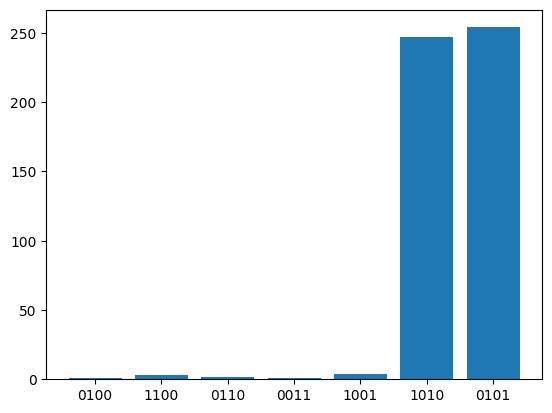

In [10]:
import matplotlib.pyplot as plt

qc = create_qaoa_circ(g, res.x[0], res.x[1])
results = tq.simulate(qc, samples=512, read_out_qubits=[0,1,2,3])
c = {}
for k, v in results.items():
    c[str(k.binary)] = v
counter = Counter(c)

plt.bar(counter.keys(), counter.values())